# Semantic Segmentation

--- Alessandro Motta, 2nd of November 2023

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models, Model

In [2]:
# Get the data
!curl -L https://github.com/michelucci/HSLU-CASML2-Deep_Learning/raw/main/COMPUTER-VISION/datasets/m2nist.zip -o /tmp/m2nist.zip
!unzip /tmp/m2nist.zip -d /tmp/m2nist

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12.2M  100 12.2M    0     0  9483k      0  0:00:01  0:00:01 --:--:-- 26.9M
Archive:  /tmp/m2nist.zip
  inflating: /tmp/m2nist/combined.npy  
  inflating: /tmp/m2nist/segmented.npy  


## Load and Inspect Data

In [3]:
images = np.load('/tmp/m2nist/combined.npy')
segmentations = np.load('/tmp/m2nist/segmented.npy')

images = images.astype(dtype=np.float32) / 255 # from 0-255 to 0-1
segmentations = segmentations.astype(dtype=np.float32) # 0, 1

# Splitting into training and test sets
train_mask = np.random.uniform(size=len(images)) < 0.75

train_images = images[train_mask]
train_segmentations = segmentations[train_mask]

test_images = images[~train_mask]
test_segmentations = segmentations[~train_mask]

del images
del segmentations

In [4]:
train_images.shape
train_segmentations.shape

(3807, 64, 84, 11)

## Build U-Net-like Model

In [5]:
def build_down(input, num_features):
  x = input
  outputs = []
  for level, features in enumerate(num_features):
    if level > 0:
      x = layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(x)
    x = layers.Conv2D(features, (5, 5), strides = (1, 1), activation = 'relu', padding='same')(x)
    x = layers.BatchNormalization(axis = 3)(x)
    outputs.append(x)
  return outputs

def build_up(down, num_outputs):
  x = down[-1]
  for level, skip in reversed(list(enumerate(down[:-1]))):
    x = layers.UpSampling2D(size = (2, 2), interpolation = 'nearest')(x)
    x = layers.Concatenate(axis = 3)([x, skip])

    if level > 0:
      x = layers.Conv2D(skip.shape[-1], (5, 5), strides = (1, 1), activation = 'relu', padding = 'same')(x)
      x = layers.BatchNormalization(axis = 3)(x)
    else:
      x = layers.Conv2D(num_outputs, (1, 1), activation = 'sigmoid')(x)

  return x

def build_model(input_shape, num_features, num_outputs):
  input = layers.Input(shape=input_shape)
  down = build_down(input, num_features)
  output = build_up(down, num_outputs)

  model = Model(inputs=input, outputs=output)
  model.compile(loss = 'binary_focal_crossentropy', optimizer = 'adam')
  return model

model = build_model([64, 84, 1], [12, 12, 12], 11)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 84, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 84, 12)           312       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 84, 12)           48        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 42, 12)           0         ['batch_normalization[0][0

In [7]:
EPOCHS = 15
history = model.fit(
  train_images, train_segmentations,
  epochs = EPOCHS, verbose = 1,
  batch_size = 32)

Epoch 1/15
119/119 [==============================] - 63s 514ms/step - loss: 0.1578
Epoch 2/15
119/119 [==============================] - 62s 519ms/step - loss: 0.0516
Epoch 3/15
119/119 [==============================] - 60s 503ms/step - loss: 0.0160
Epoch 4/15
119/119 [==============================] - 61s 508ms/step - loss: 0.0090
Epoch 5/15
119/119 [==============================] - 61s 510ms/step - loss: 0.0069
Epoch 6/15
119/119 [==============================] - 60s 503ms/step - loss: 0.0058
Epoch 7/15
119/119 [==============================] - 61s 514ms/step - loss: 0.0050
Epoch 8/15
119/119 [==============================] - 59s 496ms/step - loss: 0.0044
Epoch 9/15
119/119 [==============================] - 60s 500ms/step - loss: 0.0039
Epoch 10/15
119/119 [==============================] - 61s 513ms/step - loss: 0.0034
Epoch 11/15
119/119 [==============================] - 61s 516ms/step - loss: 0.0031
Epoch 12/15
119/119 [==============================] - 61s 507ms/step - lo

1/1 [==============================] - 0s 225ms/step


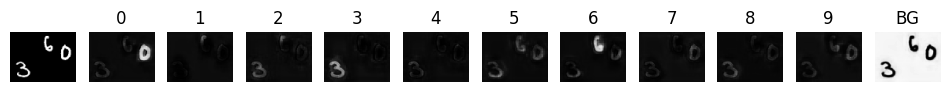

In [8]:
image = test_images[19]
preds = model.predict(np.expand_dims(image, axis=0))[0]
preds = np.split(preds, preds.shape[-1], axis=preds.ndim-1)

plt.figure(figsize=(12, 3))
plt.subplot(1, 12, 1)
plt.imshow(image, cmap='gray')
plt.gca().set_axis_off()

for i, pred in enumerate(preds):
  plt.subplot(1, 12, 2+i)

  plt.title(str(i) if i < 10 else "BG")
  plt.imshow(pred, cmap='gray', vmin=0, vmax=1)
  plt.gca().set_axis_off()

plt.show()